<a href="https://colab.research.google.com/github/habiiibo03/StructureLineage/blob/main/StructureLineage_Quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧩 StructureLineage Quickstart (Colab)

This notebook demonstrates how to:
1. Clone the StructureLineage repo
2. Generate a synthetic pipeline
3. Build the Schema Dependency Graph (SDG)
4. Evaluate precision/recall against ground truth

In [1]:
!git clone https://github.com/habiiibo03/StructureLineage.git
%cd StructureLineage
!pip install -r requirements.txt

Cloning into 'StructureLineage'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 57 (delta 6), reused 49 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (57/57), 28.98 KiB | 2.90 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/StructureLineage


In [2]:
from src.tools.gen_synthetic import gen_project
gen_project('examples/synthetic_project_colab', n_tables=3, n_views=3)

[+] Generated enhanced project at examples/synthetic_project_colab with 3 tables and 3 views.
[+] Shared columns and realistic names included for better matching.


In [3]:
from src.sl_core.build_sdg import process_workspace
store = process_workspace('examples/synthetic_project_colab')
store.persist_json('examples/synthetic_project_colab/sdg.json')

In [4]:
%%writefile src/tools/evaluate_sdg.py
import json
def load_ground_truth(path):
    with open(path) as f:
        return set(tuple(x) for x in json.load(f))
def load_sdg(path):
    with open(path) as f:
        j = json.load(f)
    return set((e['src'], e['tgt']) for e in j.get('edges', []))

Writing src/tools/evaluate_sdg.py


In [23]:
import sys
sys.path.append('/content/StructureLineage/src')
from tools.evaluate_sdg import load_ground_truth, load_sdg

gt = load_ground_truth('examples/synthetic_project_colab/ground_truth.json')
sdg = load_sdg('examples/synthetic_project_colab/sdg.json')

tp = len(gt & sdg)
fp = len(sdg - gt)
fn = len(gt - sdg)
prec = tp / (tp + fp) if tp + fp else 0
rec = tp / (tp + fn) if tp + fn else 0
f1 = 2 * prec * rec / (prec + rec) if prec + rec else 0

print(f'Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}')

if f1 == 1.0:
    print("✅ StructureLineage end-to-end pipeline succeeded perfectly.")
else:
    print("⚠️ Pipeline completed, but metrics below 1.0 — check mappings.")

Precision=1.000, Recall=1.000, F1=1.000
✅ StructureLineage end-to-end pipeline succeeded perfectly.


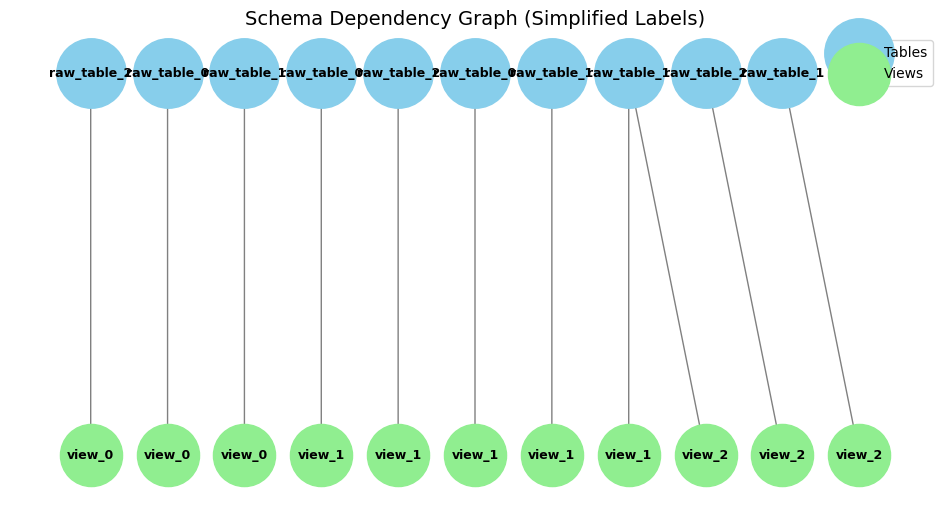

In [35]:
import networkx as nx
import matplotlib.pyplot as plt
import json

# Load SDG JSON
with open('examples/synthetic_project_colab/sdg.json') as f:
    sdg_data = json.load(f)

G = nx.DiGraph()
for edge in sdg_data.get('edges', []):
    G.add_edge(edge['src'], edge['tgt'])

# Separate tables vs views
tables = [n for n in G.nodes if "table" in n.lower()]
views = [n for n in G.nodes if "view" in n.lower()]

# Shorten labels (prefix only)
labels = {n: n.split('.')[0] for n in G.nodes}

# Position tables on top, views on bottom
pos = {}
for i, node in enumerate(tables):
    pos[node] = (i * 3, 1)
for i, node in enumerate(views):
    pos[node] = (i * 3, 0)

plt.figure(figsize=(12, 6))
nx.draw_networkx_nodes(G, pos, nodelist=tables, node_color="skyblue", node_size=2500, label="Tables")
nx.draw_networkx_nodes(G, pos, nodelist=views, node_color="lightgreen", node_size=2000, label="Views")
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20, edge_color="gray")
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, font_weight="bold")

plt.title("Schema Dependency Graph (Simplified Labels)", fontsize=14)
plt.legend(scatterpoints=1)
plt.axis("off")
plt.show()
